# Global preparations

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import time
import torch
import torchvision
import logging
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.transforms.functional import to_pil_image
from PIL import Image
from tqdm.notebook import tqdm

device = 'cuda'
summation_dtype = torch.float32
random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)
torch.backends.cudnn.enabled = True
print(torch.__version__)

2.10.0+cu128


# Text data preparation

Let's read small fineweb fragment

In [2]:
import gdown
url = 'https://drive.google.com/file/d/1vWjyIpU6wvCPtx2OdV_4M3MXX6FsOpxV/view'
output = 'fineweb_texts.txt'
if not os.path.exists(output):
    gdown.download(url, output, quiet=False, fuzzy=True)
size = os.path.getsize(output)
if size < 233 * 1024 * 1024:
    raise RuntimeError(f'Download failed: file size {size/1024/1024:.1f} MB')

In [3]:
CONTEXT_SIZE = 32

In [4]:
from spiky.util.text_snippet_sampler import TextSnippetSampler

snippet_sampler = TextSnippetSampler('fineweb_texts.txt', CONTEXT_SIZE + 1, 1000, device)

In [5]:
snippet_sampler.sample_training_batch(2)

tensor([[116,  32, 119, 111, 117, 108, 100,  32,  98, 101,  32, 109,  97, 110,
         121,  32, 121, 101,  97, 114, 115,  44,  32, 105, 102,  32, 101, 118,
         101, 114,  44,  32,  98],
        [116,  32, 100, 101, 110, 115, 105, 116, 105, 101, 115,  32, 111, 102,
          32, 116, 111, 114, 114, 101, 110, 116,  32, 115,  97, 108,  97, 109,
          97, 110, 100, 101, 114]], device='cuda:0', dtype=torch.int32)

In [6]:
snippet_sampler.batch_to_text(snippet_sampler.sample_training_batch(4))

['e islandâ\x80\x99s port, so crowded wit',
 'am 1,281 km. Now China seems to h',
 ' we?\nMake a promise to yourself, ',
 ' Z, ages 18 to 38 in 2019 â\x80\x93 52%']

In [7]:
for test_batch in snippet_sampler.testing_batches_iterator(4):
    print(snippet_sampler.batch_to_text(test_batch))
    break

[' in any other higher education se', 'n Vidal discovers, other causes a', 'ers, gorillas, and other celebrit', 'ination of their representatives,']


# Simple LUT transformer

In [38]:
from spiky.lut.LUTLayer import GradientPolicy, GradientType, SynapseMeta
from spiky.lut.LUTTransformer import LUTTransformer
from spiky.lut.tests.gt_lut_product import GTLUTProductTransformer
lut_transformer = None
optimizer = None
sched = None
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
lut_transformer = LUTTransformer(
    vocab_size=256,
    embedding_dim=32,
    context_size=CONTEXT_SIZE,
    positional_dim=4,
    num_layers=6,
    num_heads=4,
    n_detectors=16,
    n_anchors_per_detector_attention=6,
    n_anchors_per_detector=10,
    concatenation_product=True,
    dropout=0.1,
    use_batch_norm=False,
    weights_gradient_policy=GradientPolicy(GradientType.Internal),
    device=device,
    seed=random_seed,
    _forward_group_size=32,
    _backward_group_size=32
)
print(lut_transformer)

LUTTransformer(
  (token_embedder): Embedding(256, 32)
  (layers): ModuleList(
    (0-5): 6 x ModuleDict(
      (attention_lut): LUTLayer(32 inputs, 64 detectors, 32 outputs, 6 anchors per detector)
      (attention_dropout): Dropout(p=0.1, inplace=False)
      (attention_bn): None
      (ffn): LUTLayer(32 inputs, 16 detectors, 32 outputs, 10 anchors per detector)
      (ffn_dropout): Dropout(p=0.1, inplace=False)
      (ffn_bn): None
    )
  )
  (unembedder): LUTLayer(32 inputs, 16 detectors, 256 outputs, 10 anchors per detector)
)


In [39]:
total = sum(p.numel() for p in lut_transformer.parameters())
trainable = sum(p.numel() for p in lut_transformer.parameters() if p.requires_grad)

print("total:", total)
print("trainable:", trainable)
print("frozen:", total - trainable)

total: 812702208
trainable: 812694016
frozen: 8192


In [40]:
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from spiky.util.torch_utils import make_lr_getter

def lr_func(t):
    return min(
        1.0 / (1 + t)**0.5,
        (t / 4000.0) / 4000.0**0.5
    )

lr = 1.0
optimizer = optim.SGD(lut_transformer.parameters(), lr=lr)
#optimizer = optim.Adam(lut_transformer.parameters(), lr=lr)

steps=1000000
batch_size = 128
# sched = torch.optim.lr_scheduler.CosineAnnealingLR(
#     optimizer, T_max=steps
# )
sched = LambdaLR(optimizer, lr_lambda=lr_func)
#sched = None
lut_transformer.set_external_learning_rate_hook(make_lr_getter(optimizer))

In [41]:
lut_train_losses = []
lut_test_losses = []

In [42]:
import torch
import torch.nn.functional as F

test_batch_size = 128

def generate_text_lut(lut_model, prefix, length, device):
    ctx = list(prefix.encode("utf-8"))
    ctx = ctx[-CONTEXT_SIZE:]

    for _ in range(length):
        x = torch.zeros([CONTEXT_SIZE], dtype=torch.long, device=device).unsqueeze(0)
        trunc_ctx = ctx[-CONTEXT_SIZE:]
        x[0, -len(trunc_ctx):] = torch.tensor(trunc_ctx, dtype=torch.long, device=device) 
        logits = lut_model(x)
        probs = torch.softmax(logits[:,-1,:], dim=-1)[0]
        next_id = torch.multinomial(probs, 1).item()
        ctx.append(next_id)

    ctx_safe = [c if c != 0 else 32 for c in ctx]
        
    return bytes(ctx_safe).decode("latin1", errors="ignore")

def evaluate_model(model, sampler, B):
    model.eval()
    losses = []
    device = next(model.parameters()).device

    with torch.no_grad():
        for batch in sampler.testing_batches_iterator(B):   # [B, C]
            inp = batch[:, :-1]          # [B, C-1]
            tgt = batch[:, 1:].long()    # [B, C-1]

            logits = model(inp)   # [B, C-1, 256]

            B_, T, V = logits.shape
            loss = F.cross_entropy(
                logits.reshape(B_ * T, V),
                tgt.reshape(B_ * T)
            )
            losses.append(loss.item())

    # ---- small generation demo ----
    prefix = "Once upon a time "
    gen = generate_text_lut(model, prefix, length=80, device=device)
    print("\n[GEN]:", gen, "\n")

    model.train()
    return sum(losses) / len(losses) #  / (CONTEXT_SIZE * B)

In [ ]:
test_every=1000
train_loss = None
alpha = 0.01

pbar = tqdm(total=steps)
lut_transformer.train()

for step in range(0, steps + 1):
    x = snippet_sampler.sample_training_batch(batch_size)   # [B, C]
    inp = x[:, :-1]                                         # [B, C-1]
    tgt = x[:, 1:].long()                                   # [B, C-1]

    logits = lut_transformer(inp)      # [B, C-1, 256]

    B, T, V = logits.shape
    loss = F.cross_entropy(
        logits.reshape(B * T, V),
        tgt.reshape(B * T),
        reduction='none'
    ).sum()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if sched is not None:
        for _ in range(x.shape[0]):
            sched.step()

    loss_value = loss.item() / (CONTEXT_SIZE * batch_size)
    train_loss = loss_value if train_loss is None else (1 - alpha) * train_loss + alpha * loss_value
    pbar.update(1)
    if step % 10 == 0:
        pbar.set_description(f"loss={train_loss:.4f}, lr {lr if sched is None else sched.get_last_lr()[0]:.8f}")

    if step % test_every == 0:
        test_loss = evaluate_model(lut_transformer, snippet_sampler, test_batch_size)
        if len(lut_train_losses) == 0 or step > 0:
            lut_train_losses.append(train_loss)
            lut_test_losses.append(test_loss)
        print(f"[TEST] step {step}: loss={test_loss:.4f}")

  0%|          | 0/1000000 [00:00<?, ?it/s]


í½A¡¨­Ó£4p§T¡`aPßÅü©Ø»84_[CÜs5ûS¬_ë4AmÒÁ»í³ ·q;ïÞ

[TEST] step 0: loss=5.5452

[GEN]: Once upon a time likespects. The generamer devellay mension. Somebould âorger am Onove.
Theinar 

[TEST] step 1000: loss=1.8809

[GEN]: Once upon a time vatch in virh an ho makes and felexenn to reaucods of which may have it vireins, 

[TEST] step 2000: loss=1.7728

[GEN]: Once upon a time EmpanÄÐ, higher Cues when different indo might could is, it in their wate of pub 

[TEST] step 3000: loss=1.7185


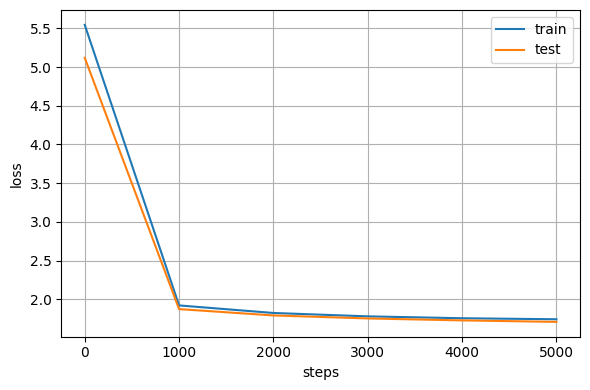

In [14]:
import matplotlib.pyplot as plt

# assume train_losses and test_losses are Python lists of equal length

steps = [i * 1000 for i in range(len(lut_train_losses))]

plt.figure(figsize=(6,4))
plt.plot(steps, lut_train_losses, label="train")
plt.plot(steps, lut_test_losses, label="test")

plt.xlabel("steps")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()